# Forecasting Future Trades on the S&P 500

In this project we'll be forecasting time-series data of S&P 500 from a dataset of [Yahoo Stock Price](https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price) from 2010 to 2015 using Recurrent Neural Network (RNN). 

## Data Wrangling and Exploration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers

# Seed code
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
df = pd.read_csv('yahoo_stock.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


We'll be using a column `Adj Close` since it's the fixed final price after adjustments for all applicable splits and dividend distributions.

In [3]:
df = df[['Date', 'Adj Close']]
df = df.sort_values('Date')
df = df.set_index('Date')

df.head()

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


Let's check if the data is clean, with `(1)` no missing values, `(2)` no major outliers, and `(3)` sorted by the relevant column containing the date or time information.

In [4]:
print(f'Missing Values: \n{df.isna().sum()}')
print(f'Describe: \n{df.describe()}')
print(f'Skew: \n{df.skew()}')

Missing Values: 
Adj Close    0
dtype: int64
Describe: 
         Adj Close
count  1825.000000
mean   2647.856284
std     407.301177
min    1829.079956
25%    2328.949951
50%    2683.340088
75%    2917.520020
max    3626.909912
Skew: 
Adj Close    0.081869
dtype: float64


* No missing values ✅
* Reasonable range ✅
* Sorted by date ✅

Let's proceed to visualizing the data to get a better picture.

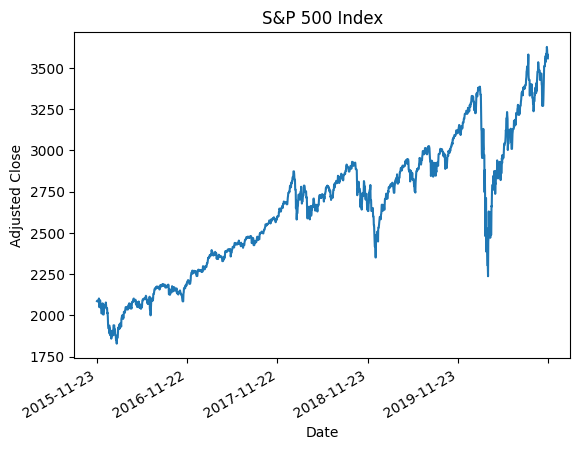

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the data
plt.plot(df)

# Add title and axis labels
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.show()

Through the 5 years of data, we can see a pattern (not just some random noise) like dips and spikes. From this data, we can build and train a model. Since we're using RNN that has inputs of different format, we'll go to data pre-processing beforehand.

## Data Pre-processing

Here's what we're going to do:
* Divide the data into `train`, `validataion`, and `test` set
    * We're dealing with a time-series data, so divide it accordingly.
* Scaling the data to be between `0` and `1`, 
* Create time windows for each dataset, and
* Reshape the data into NumPy arrays, a format required for the RNN model

In [6]:
# Split the data to training and set 
# (sequentially--not randomly) using 2:1:1
train_size      = int(len(df) * 0.5)
validation_size = int(len(df) * 0.25)

train_df      = df.iloc[ 0:train_size, : ]
validation_df = df.iloc[ train_size:(train_size+validation_size), : ]
test_df       = df.iloc[ (train_size+validation_size):len(df), : ]

from sklearn.preprocessing import MinMaxScaler

# Fit scaler
scaler = MinMaxScaler()
scaler.fit(train_df)

# Scale data
train      = pd.DataFrame(scaler.transform(train_df),
                 columns=['Adj Close'], index=train_df.index)
validation = pd.DataFrame(scaler.transform(validation_df),
                 columns=['Adj Close'], index=validation_df.index)
test       = pd.DataFrame(scaler.transform(test_df),
                 columns=['Adj Close'], index=test_df.index)

# Make a function to apply time windows
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - 1 - window_size):
        window = orig_dataset.iloc[i : (i + window_size), 0]
        target = orig_dataset.iloc[(i + window_size), 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Set the desired window_size
window_size = 10

# Apply the function to each set
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# `Reshape` the data into NumPy arrays
X_train = np.reshape(X_train, 
    (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, 
    (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, 
    (X_test.shape[0], 1, X_test.shape[1]))

## Build and Train a Basic RNN Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()

model.add(layers.SimpleRNN(10,
    input_shape = (1, window_size),
    activation = 'relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.summary()

model.fit(X_train, y_train, epochs=10, verbose=0)

y_pred_validation = model.predict(X_validation)

from sklearn.metrics import r2_score
print(f'R2 Score: {r2_score(y_validation, y_pred_validation)}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                210       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
14/14 [==============================] - 0s 1ms/step
R2 Score: 0.8453330398861765


R2 score of `SimpleRNN` reaches `84.53%`, the model seems pretty good on forecasting the trades. That being said, let's try another types of layers to see the best performance.

## Build and Train an LSTM Model

Let's compare the model when we change the `SimpleRNN` to `LSTM` and `GRU`

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()

model.add(layers.LSTM(10,
    input_shape = (1, window_size),
    activation = 'relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.summary()

model.fit(X_train, y_train, epochs=10, verbose=0)

y_pred_validation = model.predict(X_validation)

from sklearn.metrics import r2_score
print(f'R2 Score: {r2_score(y_validation, y_pred_validation)}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
14/14 [==============================] - 0s 1ms/step
R2 Score: 0.7831018404801928


With R2 score of `78.31%` in `LSTM`, it may seem that `SimpleRNN` has a better performance in forecasting the trades. But we're dealing with time-series sequential data, and `LSTM` is better in handling it relative to `SimpleRNN` in the way that it handles memory and dependencies between time steps. Therefore, we'll stick to `LSTM` for now.

## Add a Convolutional Layer

Let's try adding a convolutional layer before the `LSTM` layer and see if that makes a difference.

In [9]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(64, 1, activation='relu',
    input_shape = (1, window_size)))
model.add(layers.MaxPooling1D(1))
model.add(layers.LSTM(10, activation = 'relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.summary()

model.fit(X_train, y_train, epochs=10, verbose=0)

y_pred_validation = model.predict(X_validation)

from sklearn.metrics import r2_score
print(f'R2 Score: {r2_score(y_validation, y_pred_validation)}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10)                3000      
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,825
Trainable params: 3,825
Non-trainable params: 0
____________________________________________________

With R2 score of `85.57%` with `Conv1D`, an addition of `Conv1D` makes the `LSTM` model performance a little bit better. We can amp it up further with model optimization--we're looking for as adequate number of parameters possible yet with the best performance.

## Optimize the Model

We can optimize the model even more through several parameters:

* Window size
* Number of hidden layers
* Number of nodes per hidden layer
* Type of recurrent layer (`SimpleRNN`, `LSTM`, GRU`
* Inclusion (or not) of a convolutional layer
* Activation function used at each layer
* Optimizer
* Loss function
* Number of epochs

In [10]:
# Set the desired window_size
window_size = 12

# Apply the function to each set
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# `Reshape` the data into NumPy arrays
X_train = np.reshape(X_train, 
    (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, 
    (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, 
    (X_test.shape[0], 1, X_test.shape[1]))

model = tf.keras.Sequential()

model.add(layers.LSTM(48,
    input_shape = (1, window_size),
    activation = 'relu'))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.summary()

model.fit(X_train, y_train, epochs=36, verbose=0)

y_pred_validation = model.predict(X_validation)

from sklearn.metrics import r2_score
print(f'R2 Score: {r2_score(y_validation, y_pred_validation)}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 48)                11712     
                                                                 
 dense_6 (Dense)             (None, 24)                1176      
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 1)                 25        
                                                                 
Total params: 13,513
Trainable params: 13,513
Non-trainable params: 0
_________________________________________________________________
14/14 [==============================] - 0s 1ms/step
R2 Score: 0.9554911074798974


We've optimized the model with several modifications of parameters:

* `window_size` changed from `10` to `12`,
* An addition of `1` hidden layer (total `2`)
* Sequence of nodes (from input to output) : `48-24-24-1`
* Not adding a `Conv1D` layer for less amount of total parameters

This modified model increases the R2 score from `85.57%` to `95.55%`, really impressive! Now let's evaluate the performance with our test set.

## Evaluate Model Performance

In [11]:
# Make predictions on all three sets:
train_pred      = model.predict(X_train)
validation_pred = model.predict(X_validation)
test_pred       = model.predict(X_test)

print(f'R2 Score, Training Set: {r2_score(y_train, train_pred)}')
print(f'R2 Score, Validation Set: {r2_score(y_validation, validation_pred)}')
print(f'R2 Score, Training Set: {r2_score(y_test, test_pred)}')

14/14 [==============================] - 0s 1ms/step
R2 Score, Training Set: 0.9954920399938146
R2 Score, Validation Set: 0.9554911074798974
R2 Score, Training Set: 0.9432145886706381


The R2 scores hold up in all sets, with accuracy more than `94%`--a great sign!

Now it's time to visualize the performance. First up, we need to undo the scaling and windowing pre-processing we've done.

In [12]:
# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
validation_pred = scaler.inverse_transform(validation_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(df), 1))
plot_train_pred[:] = np.nan
plot_train_pred[
    window_size 
  : len(train_pred) + (1 * window_size) + 0, 
  : ] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(df), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[
    len(train_pred) + (2 * window_size) + 1 
  : len(train_pred) + len(validation_pred) + (window_size * 2) + 1, 
  : ] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(df), 1))
plot_test_pred[:] = np.nan
plot_test_pred[
    len(train_pred) + len(validation_pred) + (3 * window_size) + 2
  : len(df) - 1, 
  : ] = test_pred

Last but not least, let's plot the un-scaled and un-windowed data on top of `df` set.

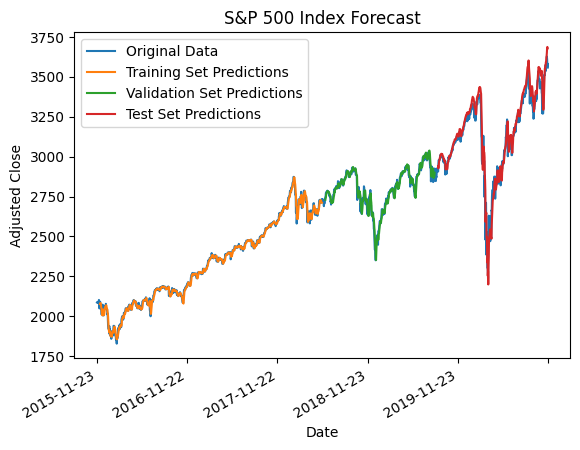

In [13]:
# Plot the original data
plt.plot(df, label='Original Data')

# Plot the predictions
plt.plot(plot_train_pred, label = 'Training Set Predictions')
plt.plot(plot_validation_pred, label = 'Validation Set Predictions')
plt.plot(plot_test_pred, label = 'Test Set Predictions')

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

The prediction in picture looks awesome! We can see tiny bits of blue (original data) on yellow (training set predictions), which indicates slight difference. But overall the predictions are good!

The real test of course being to make some predictions for the future and do some trades. At this point we're only predicting the cases. Be cautious when you're using this for reference since this project was only for educational purposes 😁